In [19]:
from movie_reviews import Review
from stemmer import Stemmer
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
stop_list = ['.', ',', '"', ')', '(', ':', ';', '?', '!', '\'', '–', '-', '{', '}', '\xa0']

stemmer = Stemmer("root_dict.json")
'''Stemmer we got from first NLP course.'''

def sanitize_text(text):
    '''Convert each word in text to basic forms, remove stop words, multiple spaces.'''
    temp = text.lower()
    for element in stop_list:
        temp = temp.replace(element, " ")
        
    for j in range(10):
        temp = temp.replace("  ", " ")

    temp = temp.split(" ")
    stemmed_text = ""
    for word in temp:
        found = stemmer.find(word) 
        if found:
            stemmed_text += found.replace(" ","") #sometimes word has space in the end
        else:
            stemmed_text += word
        stemmed_text += " "
    
    return stemmed_text

In [14]:
df = pd.read_csv("data/short_reviews_bert_10_1_50.csv")

In [15]:
df.head()

,content,rating
0,"Z każdym kolejnym razem, ten film wydaje mi si...",9
1,Mamy tutaj do czynienia z typowym amerykańskim...,4
2,lecz jeśli znasz kogoś kto oglądał ten film i ...,10
3,"że gdyby nie płonąca scena egzekucji,mógłby ro...",5
4,Dopiero po przeczytaniu książki i obejrzeniu f...,10


7.629788790344701


(array([ 2061.,  1266.,  3030.,  3056.,  4842.,  6597., 12001., 18167.,
        16226., 20250.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

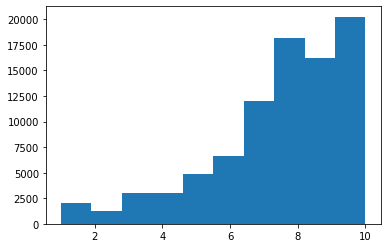

In [18]:
'''Histogram of ratings in dataset'''

df_sanitized = df.copy()
df_sanitized['content'] = df_sanitized['content'].apply(sanitize_text) 
X = df_sanitized['content']
y = df_sanitized['rating'].array
print(np.mean(y))
plt.hist(y)

In [20]:
'''Create Bag Of Words for our comments'''
clf = CountVectorizer(ngram_range=(1,1))
matrix = clf.fit_transform(X)

In [21]:
data = []
'''First idea is to find average rating for each word in our dataset'''

#feature_dict stores word index in BOW model.
feature_dict = defaultdict(str)
for i, e in enumerate(clf.get_feature_names()):
    feature_dict[i] = e

#Since "matrix" is sparse matrix - i found this the easiest way to get values out of it.
#converting sparse array to list of dictionaries
for k in tqdm(range(matrix.shape[0])):
    ngrams = defaultdict(int)
    for i, index in enumerate(matrix[k, :].indices):
        ngrams[feature_dict[index]] += matrix[k, :].data[i]
    data.append(ngrams)

100%|██████████| 87496/87496 [02:23<00:00, 609.40it/s]


In [24]:
count_dict = defaultdict(int)
sums_dict = defaultdict(int)


#calculating counts and weighted sums for each ngram (ngram count * rating)
for index, mini_dict in enumerate(tqdm(data)):
    for key in mini_dict.keys():
        if key == "":
            continue
        temp = abs(y[index] - 5) # i wanted it to be from [-5, 5]
        count_dict[key] += 1
        sums_dict[key] += mini_dict[key] * temp #mini_dict[key] is ngram count in BOW and temp is weight
#this kind of approach should show what words have higher rating on average 

100%|██████████| 87496/87496 [00:03<00:00, 25830.78it/s]


In [25]:
rev_dict = defaultdict(int)
for key in sums_dict.keys():
    if count_dict[key] < 30:
        continue
    rev_dict[key] = sums_dict[key] / count_dict[key]

#normalize each word by count of it in dataset

(array([  1.,   0.,   0.,   4.,   8.,  12.,  15.,  27.,  32.,  43.,  67.,
         79., 119., 174., 224., 293., 389., 460., 509., 573., 565., 541.,
        478., 394., 265., 206., 178., 129.,  86.,  82.,  52.,  41.,  26.,
         12.,  21.,   9.,   7.,   8.,   7.,   3.,   1.,   3.,   0.,   5.,
          3.,   0.,   1.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([1.34210526, 1.43255966, 1.52301406, 1.61346845, 1.70392285,
        1.79437725, 1.88483164, 1.97528604, 2.06574044, 2.15619483,
        2.24664923, 2.33710363, 2.42755803, 2.51801242, 2.60846682,
        2.69892122, 2.78937561, 2.87983001, 2.97028441, 3.0607388 ,
        3.1511932 , 3.2416476 , 3.33210199, 3.42255639, 3.51301079,
        3.60346518, 3.69391958, 3.78437398, 3.87482838, 3.96528277,
        4.05573717, 4.14619157, 4.23664596, 4.32710036, 4.41755476,
        4.50800915, 4.59846355, 4.68891795, 4.

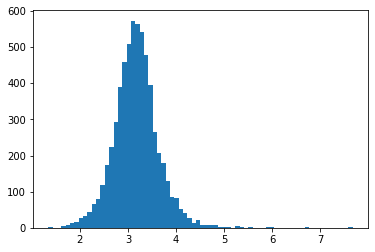

In [26]:
df_data = pd.DataFrame().from_dict(rev_dict, orient = 'index')
plt.hist(df_data[0], bins=70)
#what can be seen here that this approach gives scores with average value of 3

In [38]:
df_data.sort_values(by=0, ascending=True, inplace=True)

In [41]:
#100 best words and their rating it can be clearly seen that some are outliers like: "bla" - best rated words are quite unexcpected.
lim = 100
for i, row in df_data.iterrows():
    print(row)
    if lim == i:
        break

0    1.342105
Name: przeciętniak, dtype: float64
0    1.645833
Name: słabiutki, dtype: float64
0    1.647059
Name: klisz, dtype: float64
0    1.692737
Name: szał, dtype: float64
0    1.69697
Name: bezpłciowy, dtype: float64
0    1.744681
Name: strawny, dtype: float64
0    1.756757
Name: mizerny, dtype: float64
0    1.761905
Name: slabo, dtype: float64
0    1.764706
Name: wymęczyć, dtype: float64
0    1.764706
Name: ograny, dtype: float64
0    1.76699
Name: zawyżyć, dtype: float64
0    1.771429
Name: ochy, dtype: float64
0    1.775449
Name: potencjał, dtype: float64
0    1.795918
Name: średniak, dtype: float64
0    1.805556
Name: achy, dtype: float64
0    1.825
Name: niedorzeczność, dtype: float64
0    1.833333
Name: najzwyczajniej, dtype: float64
0    1.837134
Name: rozczarowanie, dtype: float64
0    1.83871
Name: jumper, dtype: float64
0    1.840426
Name: rewelacje, dtype: float64
0    1.842105
Name: wlec, dtype: float64
0    1.842105
Name: ujść, dtype: float64
0    1.861111
Name: naz

Name: wymyślać, dtype: float64
0    2.676471
Name: duzy, dtype: float64
0    2.677778
Name: pogubić, dtype: float64
0    2.679181
Name: serio, dtype: float64
0    2.679245
Name: homoseksualizm, dtype: float64
0    2.680365
Name: wyszły, dtype: float64
0    2.680556
Name: przyzwyczaić, dtype: float64
0    2.681159
Name: erotyczny, dtype: float64
0    2.681416
Name: skrót, dtype: float64
0    2.681818
Name: miano, dtype: float64
0    2.684211
Name: rownie, dtype: float64
0    2.684211
Name: teraźniejszość, dtype: float64
0    2.684211
Name: kluczowy, dtype: float64
0    2.685714
Name: facto, dtype: float64
0    2.685714
Name: zaszkodzić, dtype: float64
0    2.68617
Name: artystyczny, dtype: float64
0    2.686275
Name: glowny, dtype: float64
0    2.6875
Name: znieść, dtype: float64
0    2.6875
Name: realizować, dtype: float64
0    2.688172
Name: ginąć, dtype: float64
0    2.688525
Name: daleki, dtype: float64
0    2.688525
Name: znużyć, dtype: float64
0    2.688623
Name: niewiele, dtype: 

Name: póła, dtype: float64
0    2.902778
Name: zdziwienie, dtype: float64
0    2.902985
Name: dłużej, dtype: float64
0    2.903226
Name: zachodzić, dtype: float64
0    2.903226
Name: humorystyczny, dtype: float64
0    2.903226
Name: pędzić, dtype: float64
0    2.903226
Name: przywódca, dtype: float64
0    2.903226
Name: przełamać, dtype: float64
0    2.903226
Name: rozpierducha, dtype: float64
0    2.903448
Name: wzbudzić, dtype: float64
0    2.903448
Name: rozwój, dtype: float64
0    2.903846
Name: jodie, dtype: float64
0    2.904255
Name: podnieść, dtype: float64
0    2.904762
Name: chat, dtype: float64
0    2.904762
Name: przynieść, dtype: float64
0    2.904762
Name: upośledzony, dtype: float64
0    2.904762
Name: wątpliwy, dtype: float64
0    2.905146
Name: wręczyć, dtype: float64
0    2.90535
Name: 40, dtype: float64
0    2.905405
Name: grawitacja, dtype: float64
0    2.905556
Name: szansa, dtype: float64
0    2.90566
Name: jednoznaczny, dtype: float64
0    2.905882
Name: motyl, d

0    3.05042
Name: strażnik, dtype: float64
0    3.050445
Name: pani, dtype: float64
0    3.050633
Name: zapowiedź, dtype: float64
0    3.050847
Name: anioł, dtype: float64
0    3.051282
Name: bezpośredni, dtype: float64
0    3.051282
Name: mówie, dtype: float64
0    3.051282
Name: margines, dtype: float64
0    3.051724
Name: przerobić, dtype: float64
0    3.052083
Name: rachela, dtype: float64
0    3.052461
Name: bez, dtype: float64
0    3.052632
Name: możliwość, dtype: float64
0    3.052632
Name: calego, dtype: float64
0    3.052632
Name: chleb, dtype: float64
0    3.052632
Name: ameryk, dtype: float64
0    3.052632
Name: skopiować, dtype: float64
0    3.052632
Name: obój, dtype: float64
0    3.053173
Name: coraz, dtype: float64
0    3.053191
Name: ciut, dtype: float64
0    3.053254
Name: sf, dtype: float64
0    3.053476
Name: nagroda, dtype: float64
0    3.053571
Name: ponieść, dtype: float64
0    3.053846
Name: przeciwnik, dtype: float64
0    3.054054
Name: homoseksualista, dtype: 

Name: nędza, dtype: float64
0    3.157895
Name: krążyć, dtype: float64
0    3.158228
Name: gdyż, dtype: float64
0    3.158228
Name: 2012, dtype: float64
0    3.15847
Name: dokument, dtype: float64
0    3.159091
Name: zewnątrz, dtype: float64
0    3.159091
Name: wzmianka, dtype: float64
0    3.15942
Name: bar, dtype: float64
0    3.15942
Name: wzrok, dtype: float64
0    3.159574
Name: anthony, dtype: float64
0    3.159664
Name: hp, dtype: float64
0    3.159798
Name: czego, dtype: float64
0    3.16
Name: przerażać, dtype: float64
0    3.16
Name: incepcji, dtype: float64
0    3.160183
Name: trafić, dtype: float64
0    3.160377
Name: usłyszeć, dtype: float64
0    3.160535
Name: ktora, dtype: float64
0    3.160569
Name: nakręcić, dtype: float64
0    3.160622
Name: max, dtype: float64
0    3.160714
Name: hahaha, dtype: float64
0    3.16092
Name: syf, dtype: float64
0    3.16092
Name: zabójstwo, dtype: float64
0    3.16124
Name: bawić, dtype: float64
0    3.161266
Name: prawo, dtype: float64


Name: strona, dtype: float64
0    3.27658
Name: powinien, dtype: float64
0    3.276596
Name: empatia, dtype: float64
0    3.276596
Name: polowanie, dtype: float64
0    3.276596
Name: radosny, dtype: float64
0    3.276923
Name: leś, dtype: float64
0    3.277108
Name: umknąć, dtype: float64
0    3.277613
Name: sam, dtype: float64
0    3.277663
Name: książki, dtype: float64
0    3.277778
Name: przechodzić, dtype: float64
0    3.277778
Name: piłka, dtype: float64
0    3.277778
Name: czarujący, dtype: float64
0    3.277778
Name: skandal, dtype: float64
0    3.277778
Name: postąpić, dtype: float64
0    3.277778
Name: sprzedawać, dtype: float64
0    3.277778
Name: harbor, dtype: float64
0    3.278351
Name: czela, dtype: float64
0    3.278481
Name: ogladajac, dtype: float64
0    3.278689
Name: porównywać, dtype: float64
0    3.278695
Name: jedno, dtype: float64
0    3.278978
Name: czarny, dtype: float64
0    3.27907
Name: everest, dtype: float64
0    3.27907
Name: vs, dtype: float64
0    3.279

0    3.407407
Name: smierci, dtype: float64
0    3.407407
Name: 007, dtype: float64
0    3.407491
Name: jednać, dtype: float64
0    3.407767
Name: richard, dtype: float64
0    3.407895
Name: myśle, dtype: float64
0    3.408163
Name: ówczesny, dtype: float64
0    3.408602
Name: apokalipsa, dtype: float64
0    3.409091
Name: dokonać, dtype: float64
0    3.409091
Name: br, dtype: float64
0    3.409537
Name: świecie, dtype: float64
0    3.409639
Name: przeszły, dtype: float64
0    3.410256
Name: helikopter, dtype: float64
0    3.410256
Name: psycholog, dtype: float64
0    3.410256
Name: miniony, dtype: float64
0    3.410526
Name: interpretować, dtype: float64
0    3.410526
Name: postrzegać, dtype: float64
0    3.410714
Name: zjawiskowy, dtype: float64
0    3.410714
Name: miala, dtype: float64
0    3.410714
Name: królik, dtype: float64
0    3.410959
Name: dzienny, dtype: float64
0    3.411215
Name: słońce, dtype: float64
0    3.411765
Name: wszechświat, dtype: float64
0    3.411765
Name: ob

Name: artysta, dtype: float64
0    3.592593
Name: narazie, dtype: float64
0    3.592593
Name: bard, dtype: float64
0    3.593023
Name: otaczać, dtype: float64
0    3.59375
Name: zyciu, dtype: float64
0    3.59375
Name: fred, dtype: float64
0    3.59375
Name: dziesięć, dtype: float64
0    3.593857
Name: język, dtype: float64
0    3.593958
Name: gdy, dtype: float64
0    3.594203
Name: but, dtype: float64
0    3.594595
Name: forest, dtype: float64
0    3.595238
Name: movie, dtype: float64
0    3.595238
Name: przyspieszyć, dtype: float64
0    3.59542
Name: istny, dtype: float64
0    3.596154
Name: studium, dtype: float64
0    3.596685
Name: narkotyk, dtype: float64
0    3.597015
Name: orientować, dtype: float64
0    3.597015
Name: george, dtype: float64
0    3.597403
Name: hulk, dtype: float64
0    3.598361
Name: 23, dtype: float64
0    3.6
Name: han, dtype: float64
0    3.6
Name: paczka, dtype: float64
0    3.6
Name: płacz, dtype: float64
0    3.6
Name: poetycki, dtype: float64
0    3.6
N

0    4.097973
Name: kiedykolwiek, dtype: float64
0    4.1
Name: jednoczesnie, dtype: float64
0    4.1
Name: drużyna, dtype: float64
0    4.102564
Name: multikino, dtype: float64
0    4.104651
Name: dodatki, dtype: float64
0    4.109091
Name: leon, dtype: float64
0    4.11118
Name: ulubiony, dtype: float64
0    4.113636
Name: sw, dtype: float64
0    4.114286
Name: morricone, dtype: float64
0    4.115385
Name: maturalny, dtype: float64
0    4.117647
Name: imperator, dtype: float64
0    4.12069
Name: goraco, dtype: float64
0    4.123457
Name: tvp1, dtype: float64
0    4.123746
Name: żyd, dtype: float64
0    4.125
Name: wypas, dtype: float64
0    4.125
Name: pozbierać, dtype: float64
0    4.126638
Name: 3d, dtype: float64
0    4.129032
Name: namiar, dtype: float64
0    4.129032
Name: kleopatra, dtype: float64
0    4.131579
Name: sid, dtype: float64
0    4.131579
Name: voldemort, dtype: float64
0    4.131579
Name: poszukiwacz, dtype: float64
0    4.133333
Name: wzruszajacy, dtype: float64
0

In [36]:
#wors words - with lowest average score
df_data.tail(30)

,0
rozczarowywać,1.921348
polot,1.917722
karykaturalny,1.916667
chaotyczny,1.912409
wynudzić,1.884848
olej,1.882682
przeliczyć,1.882353
nazbyt,1.861111
ujść,1.842105
wlec,1.842105
